
#  オペレーティングシステム 演習 04
#  スケジューリング


名前と学生証番号を書け. Enter your name and student ID.

 * 名前 Name: 金井優希
 * 学生証番号 Student ID: 03-249217


# 1. スケジューリング


* スレッド(プロセス)が脇目もふらず実行をしているつもりでも, そのようなスレッドが(仮想)コア数以上あれば, それらすべてのスレッドが, 同時に実行されているはずはない. 
* OSは, 時折スレッドをCPUコア上で切り替えながら実行しているはずである. その様子を観測する実験をしてみよう.


以下のプログラムは擬似コードで書けば以下のようなことをしている

```
 1: int main() {
 2:   t = 現在時刻();
 3:   while (10秒たつか記録する配列があふれるまで) {
 4:     t' = 現在時刻();
 5:     t'と, 最後に見た現在時刻(t)を比べる;
 6:     tとt'の差が非常に小さければ, 自分はtからt'までCPUが割り当てられていた,
 7:     そうでなければ, tからt'まで自分は走っていなかった
 8:     (CPUが他のスレッドに割り当てられていた)と考える;
 9:     t = t';
10:   }
11:   CPUが自分に割り当てられていたと考えられる時間帯を表示する;
12: }
```

* スレッドは実質的に時計を見る以外のことをせずにひたすら走り続けている
* したがってほんとんどの時, tとt'の差は小さいのだが稀に, そうでないことがある
* それはおそらくその間他のスレッドにCPUが割り当てられており自分はその時間帯OSによって止められていた場合に生ずる



* 以下が実際のCコード


In [1]:
%%writefile sched_rec.c
#define _GNU_SOURCE
#include <assert.h>
#include <sched.h>
#include <sys/time.h>
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>


/* 時刻 begin -- end まで proc 上で動いていた記録 */
typedef struct {
  double begin;
  double end;
  int proc;
} rec_t;

/* 現在時刻を得る */
double cur_time() {
  struct timeval tp[1];
  gettimeofday(tp, 0);
  return tp->tv_sec + tp->tv_usec * 1.0E-6;
}

/* T秒間走り続け, CPUが割り当てられていたと思しき時間帯を記録する */
int run(double T, int n) {
  pid_t pid = getpid();
  double limit = cur_time() + T;
  rec_t * R = (rec_t *)calloc(n, sizeof(rec_t));
  int i = 0;
  R[i].begin = R[i].end = cur_time();
  R[i].proc = sched_getcpu();

  while (R[i].end < limit && i < n) {
    double t = cur_time(); /* 現在時刻を得る */
    int proc = sched_getcpu();
    if (t - R[i].end < 1.0E-3 && proc == R[i].proc) {
      /* 最後に見た時刻とあまり変わらない(< 1ms) -> R[i].endを増やす */
      R[i].end = t;
    } else {
      /* 最後に見た時刻から1ms以上たっている -> 新しい区間に入る */
      if (i + 1 >= n) break;
      i++;
      R[i].proc = proc;
      R[i].begin = R[i].end = cur_time();
    }
  }
  assert(i < n);
  int j;
  for (j = 0; j <= i; j++) {
    printf("%d %f %f %d %f\n", 
           pid, R[j].begin, R[j].end, R[j].proc,
           R[j].end - R[j].begin);
  }
  return 0;
}


int main(int argc, char ** argv) {
  double T = (argc > 1 ? atof(argv[1]) : 10.0);
  int n    = (argc > 2 ? atoi(argv[2]) : 100000);

  run(T, n);
  return 0;
}

Writing sched_rec.c


In [2]:
gcc -Wall -o sched_rec sched_rec.c


* 以下は1秒ほど, 単独で走らせてみる例
* 1行の読み方は以下
```
プロセスID  区間開始時刻  区間終了時刻  CPU番号 区間の長さ
```
* なお, Jupyterのbash kernelのバグによって出力が出ない場合があるかもしれない(経験上, 最初の一回がそうなることが多い). そういうときは何度か実行してみてください


In [3]:
./sched_rec 1

3241663 1730617525.131672 1730617526.131642 65 0.999970



* 各行はひとつの, 連続してOSにCPUを与えられていた時間(区間)を表している
* もし上記の結果が1行しか表示されなければそれは, 約1秒間, まったく(正確には1ms以上連続して)他のスレッドにCPUを奪われずに走っていたということになる(最後の行がほぼ1秒であることを確認せよ)
* 2行以上に渡った場合, ある区間の終了時刻と次の区間の開始時刻の差を観察してみよ(最後の行を合計するとほぼ1秒になることを確認せよ)



* 以下ではこのプロセスを複数同時に走らせると何が起きるかを観察, 可視化する
* その前に以下で, このJupyter環境(をホストしてるマシン)にいくつのCPU (正確には仮想コア)がつまれているかを見てみる


In [4]:
lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          45 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   76
  On-line CPU(s) list:    0-75
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) Platinum 8368 CPU @ 2.40GHz
    CPU family:           6
    Model:                106
    Thread(s) per core:   1
    Core(s) per socket:   2
    Socket(s):            38
    Stepping:             6
    BogoMIPS:             4788.74
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc arch_perfmon rep
                          _good nopl xtopology tsc_reliable nonstop_tsc cpuid ts
                          c_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 
                          sse4_2 x2apic movbe 


* 以下はシェルスクリプトで同時に4個, 3秒間このプロセスを走らせ, 結果はファイル sched.0, sched.1, sched.2, sched.3 に記録したもの


In [5]:
./sched_rec 3 > sched.0 | ./sched_rec 3 > sched.1 | ./sched_rec 3 > sched.2 | ./sched_rec 3 > sched.3


* sched_vis は sched_rec の結果を可視化する関数
* 同時に結果は sched.svg という画像ファイルに保存される


In [6]:
#!/usr/bin/python3
import matplotlib.collections as mc
import matplotlib.pyplot as plt

def read_dats(files):
    sched = {}
    for f in files:
        with open(f) as fp:
            for line in fp:
                fields = line.strip().split()
                [ pid,a,b,proc,dt ] = fields
                pid = int(pid)
                a = float(a)
                b = float(b)
                proc = int(proc)
                if pid not in sched:
                    sched[pid] = []
                sched[pid].append((a, b, proc))
    return sched

def sched_vis(files, start_t=0, end_t=float("inf")):
    '''
    files : sched_rec の結果が入ったファイル名のリスト 
            (例: [ "rec.0", "rec.1", .. ])
    start_t, end_t : その中で可視化したい区間の開始と終了
            (結果の中の一番早い時点を0として指定. 例えば
             begin_t=1, end_t=3, は開始から1秒目〜3秒目の
             2秒間を可視化する)
    '''
    log = read_dats(files)
    T0 = min(min(a for a, _, _ in T)  for T in log.values())
    n_procs = max(max(p for _, _, p in T) for T in log.values()) + 1
    # cmap = plt.cm.get_cmap('RdYlGn', n_procs)
    cmap = plt.get_cmap('RdYlGn', n_procs)
    segs = []
    cols = []
    fig, ax = plt.subplots()
    for i,(pid,T) in enumerate(sorted(log.items())):
        T.sort()
        for a,b,proc in T:
            t0 = max(a - T0, start_t)
            t1 = min(b - T0, end_t)
            if t0 >= t1:
                continue
            rect = plt.Rectangle((a - T0, i), b - a, 1, fc=cmap(proc))
            ax.add_patch(rect)
    ax.autoscale()
    plt.title("thread scheduling")
    plt.xlabel("time")
    plt.ylabel("thread")
    plt.ylim(0, len(log))
    plt.savefig("sched.svg")
    plt.show()

* 以下で実際に可視化
* 以下は sched.0, sched.1, sched.2, sched.3 の4つのファイルを可視化する
* start_t, end_tを指定すれば可視化の開始時刻と終了時刻を指定できる(start_t=None, end_t=Noneにすると, それぞれファイル中に含まれる最小, 最大の時刻という意味)

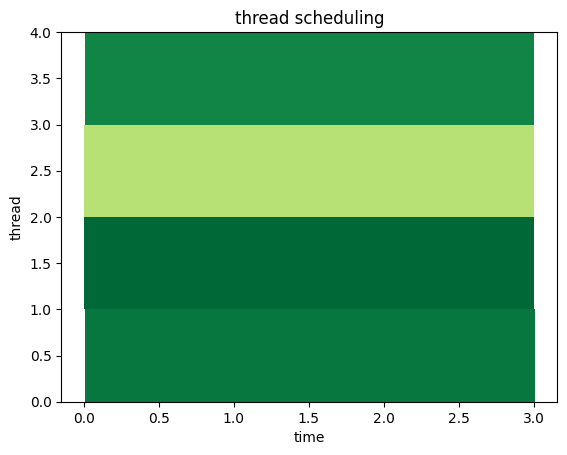

In [7]:
sched_vis(["sched.{}".format(i) for i in range(4)])
#sched_vis(["sched.{}".format(i) for i in range(4)], start_t=1.0, end_t=1.5)


* 本題は, プロセスをさらに増やしたらどうなるかということ
* 上記の書き方で複数同時に走らせるのはタイプ量の限界を超えるので, シェルスクリプトのループを使う
* 以下は8個のプロセスを3秒間走らせる
* 記録はsched.0 ... sched.7 に記録される

In [8]:
for i in $(seq 0 7); do
  taskset -c 0-3 ./sched_rec 3 > sched.${i} &
done
wait

[1] 3241776
[2] 3241777
[3] 3241778
[4] 3241779
[5] 3241780
[6] 3241781
[7] 3241782
[8] 3241783
[1]   Done                    taskset -c 0-3 ./sched_rec 3 > sched.${i}
[2]   Done                    taskset -c 0-3 ./sched_rec 3 > sched.${i}
[4]   Done                    taskset -c 0-3 ./sched_rec 3 > sched.${i}
[5]   Done                    taskset -c 0-3 ./sched_rec 3 > sched.${i}
[3]   Done                    taskset -c 0-3 ./sched_rec 3 > sched.${i}
[6]   Done                    taskset -c 0-3 ./sched_rec 3 > sched.${i}
[7]-  Done                    taskset -c 0-3 ./sched_rec 3 > sched.${i}
[8]+  Done                    taskset -c 0-3 ./sched_rec 3 > sched.${i}



* <font color="blue">実行し終えたら再び, 可視化せよ</font>


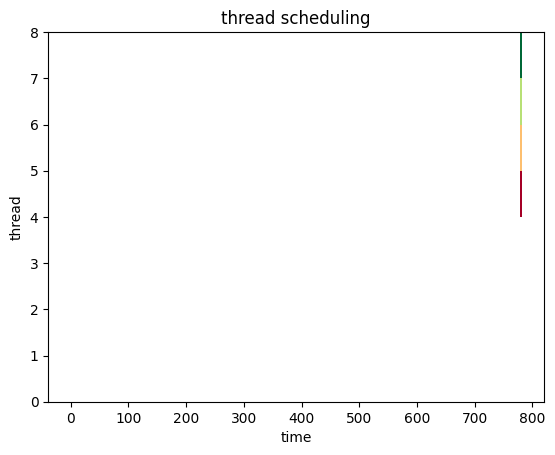

In [14]:
sched_vis(["sched.{}".format(i) for i in range(8)])
#sched_vis(["sched.{}".format(i) for i in range(8)], start_t=1.0, end_t=1.5)

In [19]:
for i in $(seq 0 3); do
  taskset -c 0-1 ./sched_rec 3 > sched.${i} &
done
wait

[1] 3242288
[2] 3242289
[3] 3242290
[4] 3242291
[1]   Done                    taskset -c 0-1 ./sched_rec 3 > sched.${i}
[3]-  Done                    taskset -c 0-1 ./sched_rec 3 > sched.${i}


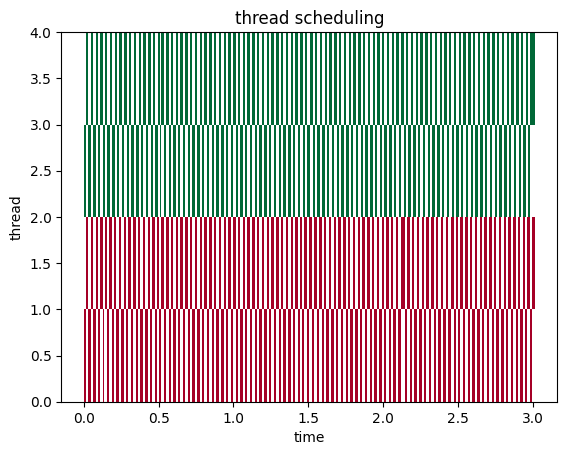

In [20]:
sched_vis(["sched.{}".format(i) for i in range(4)])
#sched_vis(["sched.{}".format(i) for i in range(8)], start_t=1.0, end_t=1.5)

* sched.svg というファイルが生成されているのでそれを開いて, 適宜拡大表示してみよ


* 上記の taskset コマンドはプロセスを特定のCPUでしか実行できないようにするコマンド(man参照)
```
taskset -c 0-3 ./sched_rec 3
```
はCPU 0 ... 3 を使えということ. <font color="blue">tasksetの引数を変えて結果の違いを観察せよ</font>
* プロセス数を 使うCPU数より少し少ないあたりから, 使うCPU数x2くらいまで, <font color="blue">色々変えて結果の違いを観察せよ</font>



* 注: 大勢で同じ環境を共有しているので, 複数の人が同時に同じ実験をすると自分は少数のプロセスしか立ち上げていなくても, 他の人のプロセスにCPUを奪われているかも知れない
* それ以外にもこのJupyterノートブック自身の処理やWebサーバの処理も行われるのでそれらにCPUを奪われることもある
* 従って, 同じ設定で実験しても結果は毎回同じとは限らない
* 自分だけの環境で走らせると結果の予測はしやすい


## 1-1. PythonでもCでも同じ
* プログラムがどの言語で書かれていてもOSがやることは同じであることを見せておく
* sched_rec.c と同じことをする Python プログラム


In [10]:
%%writefile sched_rec.py
import os
import time
import sys

# Structure to store the time period and the CPU it ran on
class Rec:
    def __init__(self, begin, end, proc):
        self.begin = begin
        self.end = end
        self.proc = proc

# Get the current time
def cur_time():
    return time.time()

def get_current_cpu():
    with open("/proc/self/stat", "r") as f:
        stat = f.read().split()
        return int(stat[38])  # 39th field in /proc/self/stat is the CPU number

# Function that simulates continuous running for T seconds and records the CPU it ran on
def run(T, n):
    pid = os.getpid()  # Get process ID
    limit = cur_time() + T
    records = [Rec(cur_time(), cur_time(), get_current_cpu()) for _ in range(n)]
    i = 0
    records[i].begin = records[i].end = cur_time()

    while records[i].end < limit and i < n:
        t = cur_time()
        proc = get_current_cpu()  # Simulate sched_getcpu with affinity
        if t - records[i].end < 1.0E-3 and proc == records[i].proc:
            records[i].end = t
        else:
            if i + 1 >= n:
                break
            i += 1
            records[i].proc = proc
            records[i].begin = records[i].end = cur_time()
    assert i < n
    for j in range(i + 1):
        print(f'{pid} {records[j].begin:.6f} {records[j].end:.6f} {records[j].proc} {records[j].end - records[j].begin:.6f}')
    return 0

def main():
    # Get command line arguments
    T = float(sys.argv[1]) if len(sys.argv) > 1 else 10.0
    n = int(sys.argv[2]) if len(sys.argv) > 2 else 100000
    run(T, n)

if __name__ == "__main__":
    main()

Writing sched_rec.py


* 上記と同様, 8 プロセスを4 仮想コア上で走らせる例

In [11]:
for i in $(seq 0 7); do
  taskset -c 0-3 python3 sched_rec.py 3 > sched.${i} &
done
wait

[1] 3241788
[2] 3241789
[3] 3241790
[4] 3241791
[5] 3241792
[6] 3241793
[7] 3241794
[8] 3241795
[1]   Done                    taskset -c 0-3 python3 sched_rec.py 3 > sched.${i}
[2]   Done                    taskset -c 0-3 python3 sched_rec.py 3 > sched.${i}
[3]   Done                    taskset -c 0-3 python3 sched_rec.py 3 > sched.${i}
[5]   Done                    taskset -c 0-3 python3 sched_rec.py 3 > sched.${i}
[6]   Done                    taskset -c 0-3 python3 sched_rec.py 3 > sched.${i}
[8]+  Done                    taskset -c 0-3 python3 sched_rec.py 3 > sched.${i}
[4]-  Done                    taskset -c 0-3 python3 sched_rec.py 3 > sched.${i}
[7]+  Done                    taskset -c 0-3 python3 sched_rec.py 3 > sched.${i}



* 可視化


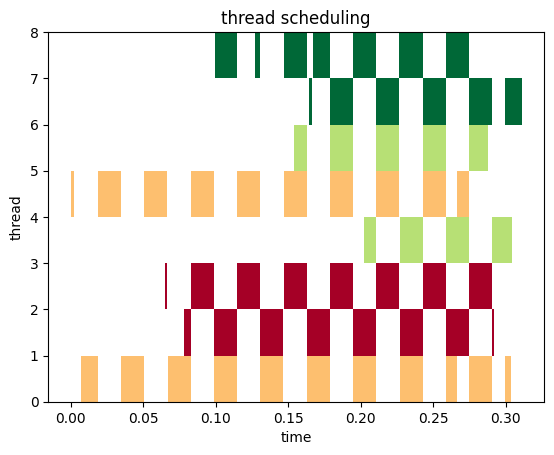

In [12]:
sched_vis(["sched.{}".format(i) for i in range(8)])
#sched_vis(["sched.{}".format(i) for i in range(8)], start_t=1.0, end_t=1.5)